# Travel Audience Data Science Challenge #

## Goal ##

One of the main problems we face at travel audience is identifying users that will eventually book a trip to an advertised destination. In this challenge, you are tasked to build a classifier to predict the conversion likelihood of a user based on previous search events, with emphasis on the feature engineering and evaluation part.

## Data ##

You are provided with two sample data sets

- `events.csv.gz` - A sample of events collected from an online travel agency, containing:
  * `ts` - the timestamp of the event
  * `event_type` - either `search` for searches made on the site, or `book` for a conversion, e.g. the user books the flight
  * `user_id` - unique identifier of a user
  * `date_from` - desired start date of the journey
  * `date_to` - desired end date of the journey
  * `origin` - IATA airport code of the origin airport
  * `destination` - IATA airport code of the destination airport
  * `num_adults` - number of adults
  * `num_children` - number of children

- `iata.csv` - containing geo-coordinates of major airports
  * `iata_code` - IATA code of the airport
  * `lat` - latitude in floating point format
  * `lon` - longitude in floating point format

## Tasks ##

Your code needs to do the following:

- Data preparation:
  - Calculate the geographic distance between origins and destinations
  - Convert raw data to a format suitable for the classification task
- Feature_engineering:
  - Based on the given input data, compute and justify three features of your choice that are relevant for predicting converters
- Experimental design:
  - Split data into test and training sets in a meaningful way
- Model:
  - A classifier of your choice that predicts the conversion-likelihood of a user

Use your best judgment to define rules and logic to compute each feature. Don't forget to comment your code!

## Deliverables ##

Code & comments that satisfy the tasks and demonstrate your coding style in Python or R. In addition, instructions on how to run your code.

We'll be evaluating the quality of your code, communication, and general solution design. We won't evaluate the actual performance of your model.

<br>
<br>

### Imports ###

In [370]:
import numpy as np
import pandas as pd
from haversine import haversine, Unit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [307]:
events = pd.read_csv('events.csv')

In [308]:
iata = pd.read_csv('iata.csv')

In [309]:
events.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1
2,2017-04-27 23:03:43,book,f953f0,2017-10-08,2017-10-11,BER,CGN,2,0
3,2017-04-27 15:17:50,book,794d35,2017-04-28,2017-05-01,BER,BCN,1,0
4,2017-04-27 22:51:57,book,ca4f94,2017-05-16,2017-05-22,DEL,BKK,4,0


In [310]:
events = events.merge(iata, how='left', left_on='origin', right_on='iata_code')

In [311]:
events.rename(columns={'lat': 'origin_lat', 'lon': 'origin_lon'}, inplace=True)
del events['iata_code']

In [312]:
events = events.merge(iata, how='left', left_on='destination', right_on='iata_code')

In [313]:
events.rename(columns={'lat': 'dest_lat', 'lon': 'dest_lon'}, inplace=True)
del events['iata_code']

In [314]:
events.columns

Index(['ts', 'event_type', 'user_id', 'date_from', 'date_to', 'origin',
       'destination', 'num_adults', 'num_children', 'origin_lat', 'origin_lon',
       'dest_lat', 'dest_lon'],
      dtype='object')

In [315]:
events['event_type'].value_counts()

search    45198
book       1809
Name: event_type, dtype: int64

In [316]:
events['trip_len'] = (pd.to_datetime(events['date_to']) - pd.to_datetime(events['date_from'])).dt.days

In [317]:
events['travel_dist'] = events.apply(lambda x: haversine((x['origin_lat'], x['origin_lon']), (x['dest_lat'], x['dest_lon']), unit=Unit.KILOMETERS), axis=1)

In [318]:
events.sort_values('ts',inplace=True)

In [319]:
events.reset_index(inplace=True)

In [320]:
df1 = events.set_index('event_type', append=True)['user_id'].unstack().add_prefix('num_')
df1 = pd.concat([df1.dropna(subset=[c]).groupby(c).cumcount().add(1) 
                                             for c in df1.columns], axis=1, keys=df1.columns)

In [321]:
events = events.join(df1.groupby(events['user_id']).ffill().fillna(0).astype(int))

In [322]:
#############################################
#
# HACK: Impute mean for the travel_len column
#
#############################################

events['trip_len'].fillna((events['trip_len'].mean()), inplace=True)

As we have a series of events that can be either `search` or `book`, and for a combination of user and journey over time, it gives us a sequence of events. Taking the last instance of that sequence of events, tells us whether it resulted in a booking, or not. 

In [323]:
events_grouped = events.groupby(['user_id', 'origin', 'destination']).tail(1)

In [324]:
events_grouped['event_type'].value_counts()

search    31870
book       1611
Name: event_type, dtype: int64

In [325]:
modeling_df = events_grouped[['num_adults', 'num_children', 'trip_len', 'travel_dist', 'num_book', 'num_search', 'event_type']]

In [326]:
modeling_df.head()

,num_adults,num_children,trip_len,travel_dist,num_book,num_search,event_type
6,1,0,7.0,10404.864529,0,1,search
10,2,0,0.0,15028.160110,0,2,search
19,2,0,9.0,10420.211956,0,2,search
20,2,0,4.0,15028.160110,1,5,book
25,1,0,0.0,6560.632422,1,3,book


In [327]:
X_train, X_test, y_train, y_test = train_test_split(modeling_df, modeling_df['event_type'],
                                                    test_size=0.3, random_state=176, stratify=modeling_df['event_type'])

In [328]:
X_train = X_train.drop('event_type', axis=1)
X_test = X_test.drop('event_type', axis=1)

In [331]:
# Create the synthetic training data
sm = SMOTE(random_state=205)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [352]:
# Train a Random Forest Classifier and generate predictions
smote_rf = RandomForestClassifier(random_state=366).fit(X_train, y_train)
preds = smote_rf.predict(X_test)

In [353]:
# Calculate accuracy metrics
accuracy = accuracy_score(y_test, smote_preds)
balanced_acc = balanced_accuracy_score(y_test, smote_preds)
precision = precision_score(y_test, smote_preds, pos_label='book')
recall = recall_score(y_test, smote_preds, pos_label='book')
f1 = f1_score(y_test, smote_preds, pos_label='book')

In [ ]:
# Prepare the ROC AUC calculation, and calculate
y_test_auc = np.where(y_test == 'book', 1, 0)
preds_auc = np.where(preds == 'book', 1, 0)

auc = roc_auc_score(y_test_auc, preds_auc)

<br>
<br>

### Presenting the results of the Random Forest model ###

Now we're going to create a DataFrame which shows the various accuracy metrics for the model:

In [365]:
metrics = {'Metrics': [accuracy, balanced_acc, precision, recall, f1, auc]}
metrics_df = pd.DataFrame(metrics, index=['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC'])
metrics_df

,Metrics
Accuracy,0.984968
Balanced Accuracy,0.972446
Precision,0.779461
Recall,0.958592
F1 Score,0.859796
AUROC,0.972446


<br>
<br>

### ROC Curve for the SMOTE Random Forest ###

Let's plot the Receiver Operating Characteristic curve for the our model. This curve plots the relationship between the True Positive Rate (a.k.a. Sensitivity) and the False Positive Rate (a.k.a. 1 - Specificity).

In [369]:
fpr, tpr, thresholds = roc_curve(y_test_auc, preds_auc)

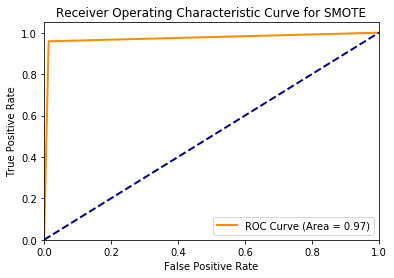

In [371]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC Curve (Area = %0.2f)' % smote_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for SMOTE')
plt.legend(loc="lower right")

<br>
<br>

### Feature Importance ###

Finally, let's show the relative importance of the features. Feature importance is calculated by reshuffling the rows of each feature, re-fitting the model and re-predicting, and calculating the drop in accuracy after this is done.

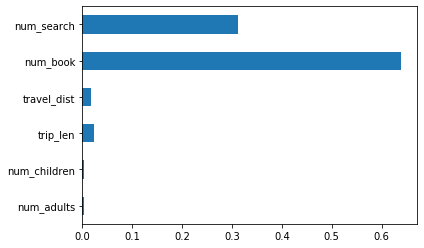

In [373]:
feat_importances = pd.Series(smote_rf.feature_importances_, index=X_train.columns)
feat_importances.plot(kind='barh')